In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout

In [2]:
#reading dataset
exchange_data = pd.read_csv('INRUSD.csv')
exchange_data.head()

,Date,Price,Open,High,Low,Volume,Chg%
0,2023-01-31,0.01223,0.01227,0.01227,0.01219,0,-0.30%
1,2023-01-30,0.01227,0.01227,0.01228,0.01224,0,0.00%
2,2023-01-29,0.01227,0.01227,0.01227,0.01227,0,0.00%
3,2023-01-27,0.01227,0.01228,0.01228,0.01225,0,-0.07%
4,2023-01-26,0.01228,0.01227,0.01229,0.01226,0,0.07%


In [3]:
exchange_data["Date"] = pd.to_datetime(exchange_data["Date"])
ind_exchange_data = exchange_data.set_index(["Date"], drop=True)

In [4]:
#checking first few records of the dataset
ind_exchange_data.head()

,Price,Open,High,Low,Volume,Chg%
Date,,,,,,
2023-01-31,0.01223,0.01227,0.01227,0.01219,0,-0.30%
2023-01-30,0.01227,0.01227,0.01228,0.01224,0,0.00%
2023-01-29,0.01227,0.01227,0.01227,0.01227,0,0.00%
2023-01-27,0.01227,0.01228,0.01228,0.01225,0,-0.07%
2023-01-26,0.01228,0.01227,0.01229,0.01226,0,0.07%


In [5]:
# sorting the dataset in ascending order of date
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame.head()

,Chg%,High,Low,Open,Price,Volume
Date,,,,,,
2016-01-03,0.00%,0.0151,0.0151,0.0151,0.0151,0
2016-01-04,-0.66%,0.0151,0.0150,0.0151,0.0150,0
2016-01-05,0.00%,0.0151,0.0150,0.0150,0.0150,0
2016-01-06,0.00%,0.0150,0.0150,0.0150,0.0150,0
2016-01-07,-0.67%,0.0150,0.0149,0.0150,0.0149,0


<AxesSubplot:xlabel='Date'>

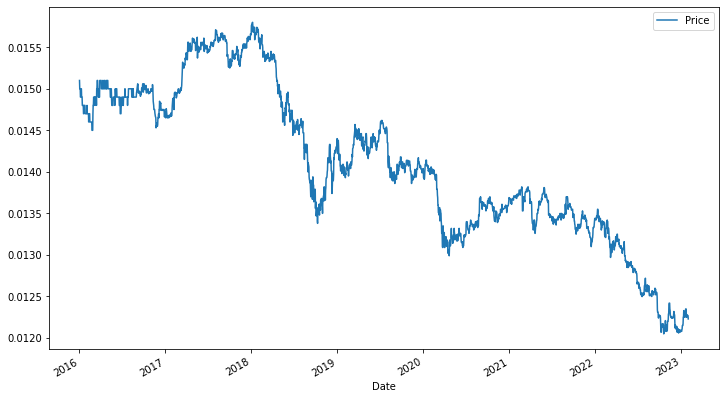

In [6]:
df = data_frame[["Price"]]

#plotting dataset to visualize the pattern of prices over the years

df.plot(kind='line',figsize=(12,7))

In [7]:
diff = df.index.values[-1] - df.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 2016 to %d"%(2016 + int(0.8*years)))

Total data: 7 years
80 percent data = 2016 to 2021


# Statistics

In [8]:
df.describe()

,Price
count,2217.000000
mean,0.014097
std,0.000940
min,0.012050
25%,0.013420
50%,0.014040
75%,0.014900
max,0.015800


# Train Test Split
As we have seen 80% of the data lies in the interval of 2010 and 2018 so we will train the model for the date range of 26 August 2010 to 26 August 2018 and rest will be used as the testing data

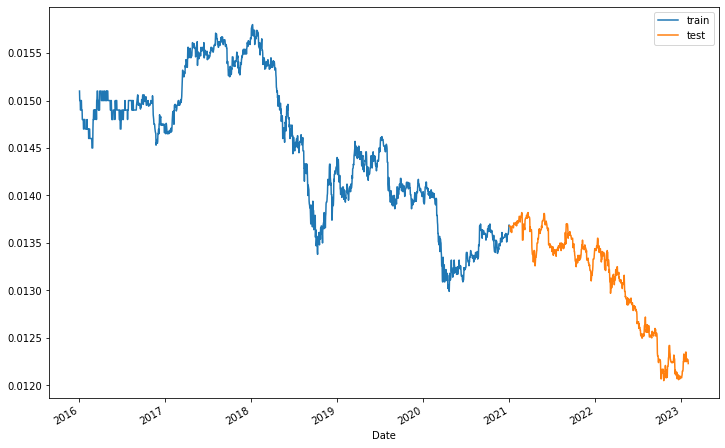

In [9]:
split_date = pd.Timestamp('01-01-2021')

train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot(kind='line',figsize=(12,8))
test.plot(ax=ax,kind='line',figsize=(12,8))
plt.legend(['train', 'test'])

# Data Normalization

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [12]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [13]:
X_train

array([[ 0.79655608],
       [ 0.66063449],
       [ 0.66063449],
       ...,
       [-1.21508348],
       [-1.16071485],
       [-1.11993837]])

# Decision Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier(max_depth =3, random_state = 42)

model_dt.fit(X_train, y_train)

# K.clear_session()
# model_lstm = Sequential()
# model_lstm.add(LSTM(50, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
# model_lstm.add(Dense(1))
# model_lstm.summary()

ValueError: ignored

# ANN

In [15]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                24        
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/200
1565/1565 [==============================] - 4s 2ms/step - loss: 0.0130 - rmse: 0.1139
Epoch 2/200
1565/1565 [==============================] - 3s 2ms/step - loss: 0.0064 - rmse: 0.0800
Epoch 3/200
1565/1565 [==============================] - 2s 1ms/step - loss: 0.0059 - rmse: 0.0769
Epoch 4/200
1565/1565 [==============================] - 2s 2ms/step - loss: 0.0058 - rmse: 0.0763
Epoch 5/200
1565/1565 [==============================] - 2s 2ms/step - loss: 0.0057 - rmse: 0.0756
Epoch 6/200
1565/1565 [==============================] - 3s 2ms/step - loss: 0.0057 - rmse: 0.0753
Epoch 7/200
1565/1565 [==============================] - 3s 2ms/step - loss: 0.0056 - rmse: 0.0751
Epoch 8/200
1565/1565 [==============================] - 2s 2ms/step - loss: 0.0056 - rmse: 0.0749
Epoch 9/200
1565/1565 [==============================] - 2s 2ms/step - loss: 0.0056 - rmse: 0.0749
Epoch 10/200
1565/1565 [==============================] - 2s 2ms/step - loss: 0.0056 - rmse: 0.0748
Epoch 11/

# ANN Prediction

In [17]:
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [18]:
y_pred_test = model.predict(X_test)
y_train_pred = model.predict(X_train)

train_mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(test_mse)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred)))

print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test)))
r2_test = r2_score(y_test, y_pred_test)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

49/49 [==============================] - 0s 1ms/step
The R2 score on the Train set is:	0.956
The  MAE on the Train set is:	0.168
The  RMSE on the Train set is:	0.211
The Adjusted R2 score on the Train set is:	0.955

The R2 score on the Test set is:	0.895
The Adjusted R2 score on the Test set is:	0.895
The  MAE on the Test set is:	0.177
The  RMSE on the Test set is:	0.236


# ANN Prediction Plot

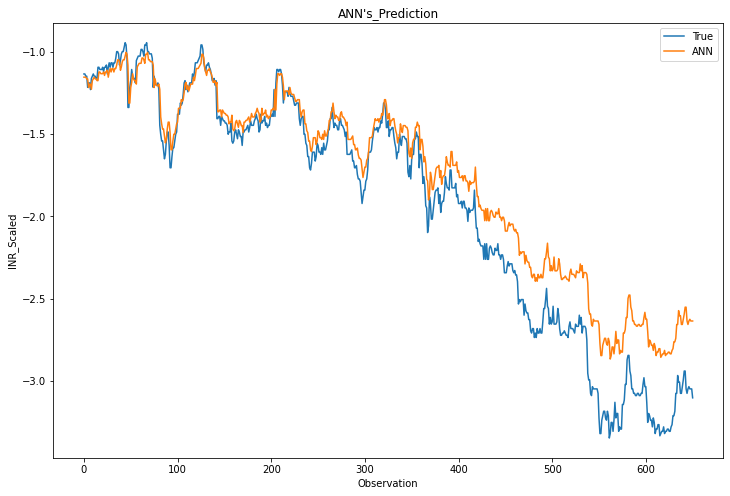

In [19]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test, label='ANN')
plt.title("ANN's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

# Data preprocessing for LSTM

In [19]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# LSTM

In [20]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(1, X_train.shape[1]), 
                    activation='relu', 
                    kernel_initializer='lecun_uniform', 
                    return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_lstm.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
1565/1565 [==============================] - 4s 2ms/step - loss: 0.0333 - rmse: 0.1824
Epoch 2/100
1565/1565 [==============================] - 4s 3ms/step - loss: 0.0063 - rmse: 0.0795
Epoch 3/100
1565/1565 [==============================] - 3s 2ms/step - loss: 0.0060 - rmse: 0.0774
Epoch 4/100
1565/1565 [==============================] - 3s 2ms/step - loss: 0.0059 - rmse: 0.0767
Epoch 5/100
1565/1565 [==============================] - 4s 2ms/step - loss: 0.0058 - rmse: 0.0763
Epoch 6/100
1565/1565 [==============================] - 4s 2ms/step - loss: 0.0058 - rmse: 0.0762
Epoch 7/100
1565/1565 [==============================] - 3s 2ms/step - loss: 0.0058 - rmse: 0.0763
Epoch 8/100
1565/1565 [==============================] - 3s 2ms/step - loss: 0.0058 - rmse: 0.0765
Epoch 9/100
1565/1565 [==============================] - 4s 3ms/step - loss: 0.0059 - rmse: 0.0766
Epoch 10/100
1565/1565 [==============================] - 3s 2ms/step - loss: 0.0059 - rmse: 0.0767
Epoch 11/

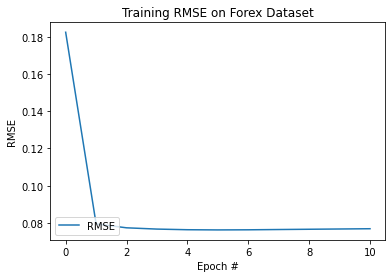

In [25]:
N = 44

plt.figure()

plt.plot(np.arange(0, N), history_model_lstm.history["rmse"], label="RMSE")
plt.title("Training RMSE on Forex Dataset")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend(loc="lower left")

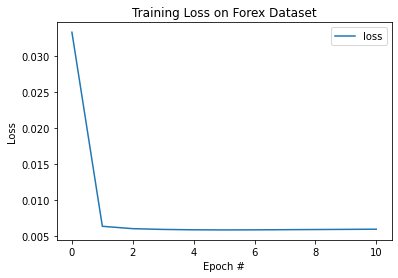

In [26]:
N = 11

plt.figure()

plt.plot(np.arange(0, N), history_model_lstm.history["loss"], label="loss")
plt.title("Training Loss on Forex Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

# LSTM Prediction

In [27]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)

train_mse = metrics.mean_squared_error(y_train, y_train_pred_lstm)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test_lstm)
rmse_test = np.sqrt(test_mse)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred_lstm)))

print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test_lstm)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

49/49 [==============================] - 0s 2ms/step
The R2 score on the Train set is:	0.935
The  MAE on the Train set is:	0.196
The  RMSE on the Train set is:	0.256
The Adjusted R2 score on the Train set is:	0.935

The R2 score on the Test set is:	0.652
The Adjusted R2 score on the Test set is:	0.652
The  MAE on the Test set is:	0.320
The  RMSE on the Test set is:	0.430


# LSTM Prediction Plot

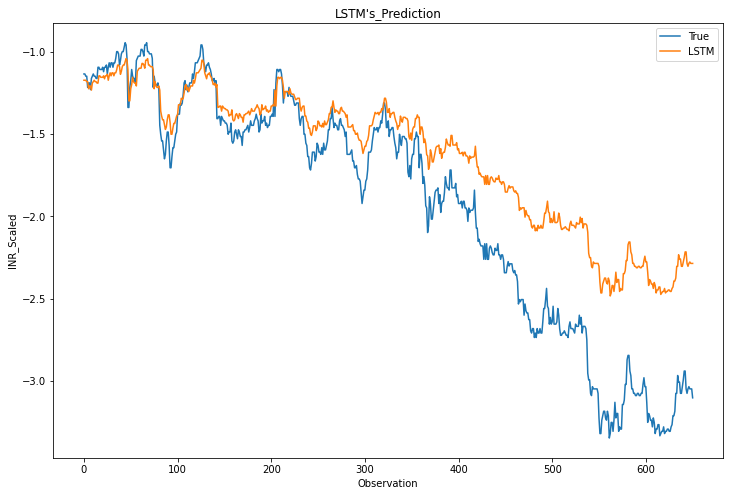

In [28]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

# GRU

In [29]:
from keras.layers import GRU
K.clear_session()
model_gru = Sequential()
model_gru.add(GRU(7, input_shape=(1, X_train.shape[1]), 
                  activation='linear', 
                  kernel_initializer='lecun_uniform', 
                  return_sequences=False))
model_gru.add(Dense(1))
model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 7)                 210       
                                                                 
 dense (Dense)               (None, 1)                 8         
                                                                 
Total params: 218
Trainable params: 218
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_gru.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
history_model_gru = model_gru.fit(X_tr_t, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
1565/1565 [==============================] - 4s 2ms/step - loss: 0.0320 - rmse: 0.1790
Epoch 2/100
1565/1565 [==============================] - 3s 2ms/step - loss: 0.0066 - rmse: 0.0815
Epoch 3/100
1565/1565 [==============================] - 5s 4ms/step - loss: 0.0058 - rmse: 0.0760
Epoch 4/100
1565/1565 [==============================] - 3s 2ms/step - loss: 0.0056 - rmse: 0.0748
Epoch 5/100
1565/1565 [==============================] - 3s 2ms/step - loss: 0.0055 - rmse: 0.0744
Epoch 6/100
1565/1565 [==============================] - 4s 3ms/step - loss: 0.0055 - rmse: 0.0741
Epoch 7/100
1565/1565 [==============================] - 3s 2ms/step - loss: 0.0055 - rmse: 0.0740
Epoch 8/100
1565/1565 [==============================] - 3s 2ms/step - loss: 0.0055 - rmse: 0.0740
Epoch 9/100
1565/1565 [==============================] - 3s 2ms/step - loss: 0.0055 - rmse: 0.0739
Epoch 10/100
1565/1565 [==============================] - 4s 2ms/step - loss: 0.0055 - rmse: 0.0739
Epoch 11/

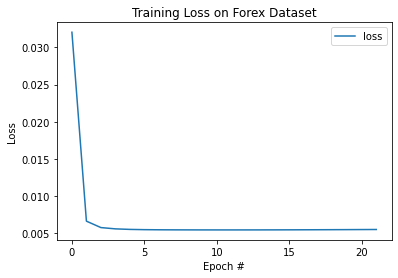

In [34]:
N = 22

plt.figure()

plt.plot(np.arange(0, N), history_model_gru.history["loss"], label="loss")
plt.title("Training Loss on Forex Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

# GRU Prediction

In [35]:
y_pred_test_gru = model_gru.predict(X_tst_t)
y_train_pred_gru = model_gru.predict(X_tr_t)

train_mse = metrics.mean_squared_error(y_train, y_train_pred_gru)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test_gru)
rmse_test = np.sqrt(test_mse)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_gru)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred_gru)))

print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred_gru)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_gru)))
r2_test = r2_score(y_test, y_pred_test_gru)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test_gru)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

49/49 [==============================] - 0s 2ms/step
The R2 score on the Train set is:	0.965
The  MAE on the Train set is:	0.150
The  RMSE on the Train set is:	0.188
The Adjusted R2 score on the Train set is:	0.965

The R2 score on the Test set is:	0.696
The Adjusted R2 score on the Test set is:	0.695
The  MAE on the Test set is:	0.280
The  RMSE on the Test set is:	0.402


# GRU Prediction Plot

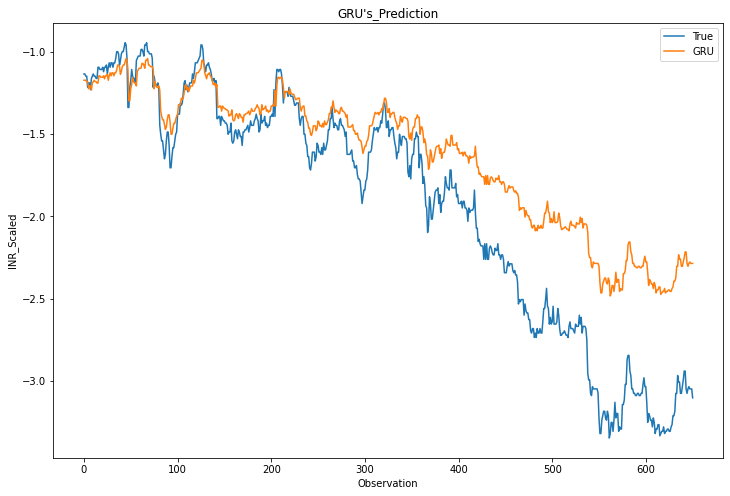

In [36]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='GRU')
plt.title("GRU's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [37]:
inv_yhat = sc.inverse_transform(y_pred_test_gru)

inv_yhat

array([[0.01366719],
       [0.01366719],
       [0.01366719],
       [0.01365917],
       [0.01365917],
       [0.01361962],
       [0.01363533],
       [0.01363533],
       [0.01361182],
       [0.01365118],
       [0.01365917],
       [0.01366719],
       [0.01365917],
       [0.01365917],
       [0.01365118],
       [0.01365118],
       [0.01369147],
       [0.01369147],
       [0.01368334],
       [0.01368334],
       [0.01368334],
       [0.01369147],
       [0.01367525],
       [0.01369147],
       [0.01369147],
       [0.01369964],
       [0.01366719],
       [0.01369147],
       [0.01370785],
       [0.01369147],
       [0.01370785],
       [0.01370785],
       [0.01369147],
       [0.01370785],
       [0.01370785],
       [0.01372437],
       [0.01374944],
       [0.01374944],
       [0.01374105],
       [0.01369964],
       [0.01371609],
       [0.01374105],
       [0.01374944],
       [0.01374944],
       [0.01376635],
       [0.0137834 ],
       [0.01377485],
       [0.013

In [38]:
inv_ytest = sc.inverse_transform(y_test)

inv_ytest

array([[0.01368],
       [0.01368],
       [0.01367],
       [0.01367],
       [0.01362],
       [0.01364],
       [0.01364],
       [0.01361],
       [0.01366],
       [0.01367],
       [0.01368],
       [0.01367],
       [0.01367],
       [0.01366],
       [0.01366],
       [0.01371],
       [0.01371],
       [0.0137 ],
       [0.0137 ],
       [0.0137 ],
       [0.01371],
       [0.01369],
       [0.01371],
       [0.01371],
       [0.01372],
       [0.01368],
       [0.01371],
       [0.01373],
       [0.01371],
       [0.01373],
       [0.01373],
       [0.01371],
       [0.01373],
       [0.01373],
       [0.01375],
       [0.01378],
       [0.01378],
       [0.01377],
       [0.01372],
       [0.01374],
       [0.01377],
       [0.01378],
       [0.01378],
       [0.0138 ],
       [0.01382],
       [0.01381],
       [0.01375],
       [0.01353],
       [0.01353],
       [0.01362],
       [0.01365],
       [0.0137 ],
       [0.01367],
       [0.01366],
       [0.01366],
       [0.

In [39]:
test_mse = metrics.mean_squared_error(inv_ytest, inv_yhat)
rmse_test = np.sqrt(test_mse)


print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(inv_ytest, inv_yhat)))
r2_test = r2_score(inv_ytest, inv_yhat)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(inv_ytest, inv_yhat)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))

The R2 score on the Test set is:	0.696
The Adjusted R2 score on the Test set is:	0.695
The  MAE on the Test set is:	0.000
The  RMSE on the Test set is:	0.000


In [40]:
test.head()

,Price
Date,
2021-01-01,0.01368
2021-01-03,0.01368
2021-01-04,0.01368
2021-01-05,0.01367
2021-01-06,0.01367


In [41]:
col1 = pd.DataFrame(inv_ytest, columns=['Price'])

col2 = pd.DataFrame(inv_yhat, columns=['GRU_prediction'])

col3 = pd.DataFrame(history_model_lstm.history['rmse'], columns=['RMSE'])
results = pd.concat([col1, col2, col3], axis=1)
results.to_csv('Prediction_USD_INR_GRU.xlsx')

In [42]:
results.head()

,Price,GRU_prediction,RMSE
0,0.01368,0.013667,0.182400
1,0.01368,0.013667,0.079471
2,0.01367,0.013667,0.077373
3,0.01367,0.013659,0.076688
4,0.01362,0.013659,0.076344


In [43]:
test.reset_index(level=0, inplace=True)
test.head()

,Date,Price
0,2021-01-01,0.01368
1,2021-01-03,0.01368
2,2021-01-04,0.01368
3,2021-01-05,0.01367
4,2021-01-06,0.01367


In [44]:
dfinal = test.merge(results, how='inner', left_on='Price', right_on='Price')

In [45]:
dfinal.drop_duplicates(subset="Date",inplace=True)


dfinal.head()

,Date,Price,GRU_prediction,RMSE
0,2021-01-01,0.01368,0.013667,0.1824
7,2021-01-03,0.01368,0.013667,0.1824
14,2021-01-04,0.01368,0.013667,0.1824
21,2021-01-14,0.01368,0.013667,0.1824
28,2021-02-01,0.01368,0.013667,0.1824


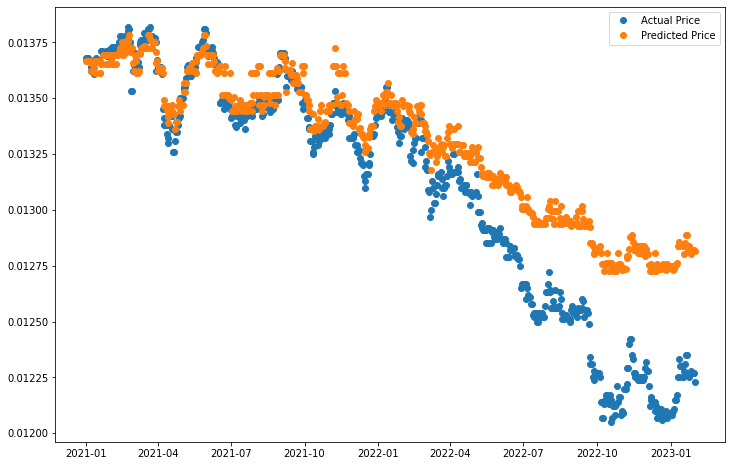

In [46]:
plt.figure(figsize=(12,8))
price_date = dfinal['Date']
price_true = dfinal['Price']
price_pred = dfinal['GRU_prediction']
plt.plot_date(price_date, price_true,label='Actual Price')
plt.plot_date(price_date, price_pred,label='Predicted Price')
plt.legend()
plt.show()

In [47]:
dfinal.describe()

,Price,GRU_prediction,RMSE
count,652.000000,652.000000,41.000000
mean,0.013096,0.013297,0.097242
std,0.000536,0.000321,0.042451
min,0.012050,0.012724,0.076242
25%,0.012580,0.012988,0.076344
50%,0.013320,0.013387,0.076596
75%,0.013490,0.013571,0.077373
max,0.013820,0.013783,0.182400
